In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import DeLASE
import h5py
from hydra import initialize, compose
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import torch
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import get_grid_params_to_use, find_noisy_data
from UniversalUnconsciousness.hdf5_utils import *
from UniversalUnconsciousness.iaaft import surrogates
from UniversalUnconsciousness.plot_utils import *
from UniversalUnconsciousness.sensory_responses import *

load_font()
plt.style.use('UniversalUnconsciousness.sci_style')

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# all_data_dir = '/orcd/data/ekmiller/001/common/datasets'
data_class = 'propofolPuffTone'
# data_class = 'anesthesiaLvrOdd'

In [15]:
# propofol dir
if data_class == 'propofolPuffTone':
    data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', data_class)
    cfg.params.data_class = 'propofolPuffTone'
    cfg.params.grid_set = 'grid_set6'
else:
    data_dir = os.path.join(cfg.params.all_data_dir, data_class, 'mat')
    cfg.params.data_class = 'anesthesiaLvrOdd'
    cfg.params.grid_set = 'grid_set6'
cfg.params.stride = 15


In [16]:
session = "Mary-Anesthesia-20160912-02"
# session = "MrJones-Anesthesia-20160123-01" # *
# session = "SPOCK_Ketamine_20210727"
# session = "SPOCK_Dexmedetomidine_20210923"
# session = "PEDRI_Ketamine_20220106"
# session = "PEDRI_Dexmedetomidine_20220324"

# session = "PEDRI_Dexmedetomidine_20220419" # LOW

In [17]:
noise_filter_info = {}
if cfg.params.noise_filter:
    os.makedirs(cfg.params.noise_filter_results_dir, exist_ok=True)
    noise_filter_dir = os.path.join(cfg.params.noise_filter_results_dir, cfg.params.data_class)
    os.makedirs(noise_filter_dir, exist_ok=True)
    noise_filter_file = f"{session}__window_{cfg.params.window}__wakethresh_{cfg.params.wake_amplitude_thresh}__anesthesiathresh_{cfg.params.anesthesia_amplitude_thresh}__electrodenum_{cfg.params.electrode_num_thresh}.pkl"
    
    print("--------------------")
    print(f"Session: {session}")
    print("--------------------")
    if noise_filter_file in os.listdir(noise_filter_dir):
        noise_filter_info[session] = pd.read_pickle(os.path.join(noise_filter_dir, noise_filter_file))
    else:
        print("Finding noisy data...")
        window_df, bad_electrodes, valid_window_starts = find_noisy_data(cfg, session)
        noise_filter_info[session] = dict(
            window_df=window_df,
            bad_electrodes=bad_electrodes,
            valid_window_starts=valid_window_starts
        )
        pd.to_pickle(noise_filter_info[session], os.path.join(noise_filter_dir, noise_filter_file))
    
    print(f"{len(noise_filter_info[session]['bad_electrodes'])} bad electrodes, {len(noise_filter_info[session]['valid_window_starts'])} valid windows (out of {len(noise_filter_info[session]['window_df'])} total windows)")
else:
    bad_electrodes = []
    valid_window_starts = None
    noise_filter_info = dict(
        window_df=None,
        bad_electrodes=bad_electrodes,
        valid_window_starts=valid_window_starts
    )

--------------------
Session: Mary-Anesthesia-20160912-02
--------------------
3 bad electrodes, 37 valid windows (out of 55 total windows)


In [18]:
session_file = h5py.File(os.path.join(data_dir,f"{session}.mat"), 'r')

In [19]:
trial_type = 'toneOnly'

In [20]:
sensory_responses, dt = get_sensory_responses_propofol(cfg, session, noise_filter_info, trial_type, leadup = 250, response = 1000, area='all')

In [21]:
n_trials = 100
wake_responses = sensory_responses['awake'][:n_trials][:, 250:]
anesthesia_responses = sensory_responses['maintenance dose'][:n_trials][:, 250:]

In [22]:
electrode_areas = convert_h5_string_array(session_file, session_file['electrodeInfo']['area'][0, :])
bad_electrodes = noise_filter_info[session]['bad_electrodes']
valid_electrodes = [i for i in range(len(electrode_areas)) if electrode_areas[i] not in bad_electrodes]

# delete the bad electrodes
# bad electrodes is a list of electrode indices
good_electrodes = [i for i in range(len(electrode_areas)) if electrode_areas[i] not in bad_electrodes]
electrode_areas = electrode_areas[good_electrodes]

areas = ['all']
# areas = ['vlPFC']
pca_chosen = None
session_list = [session]

if areas[0] == 'all':
    electrodes_to_use = np.arange(len(good_electrodes))
else:
    electrodes_to_use = np.where(np.isin(electrode_areas, areas))[0]
grid_params_to_use, grid_search_results = get_grid_params_to_use(cfg, session_list, areas, pca_chosen, log=None, return_results=True, verbose=True)

--------------------
SESSION = Mary-Anesthesia-20160912-02
--------------------
list exists! loading /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/grid_searches/propofolPuffTone/grid_search_run_lists/Mary-Anesthesia-20160912-02_grid_set6_window_15...
Loading data for Mary-Anesthesia-20160912-02 - all from /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/grid_searches/propofolPuffTone/grid_search_results/Mary-Anesthesia-20160912-02/NOISE_FILTERED_15_1_1_1_stride_15/NOT_NORMED/SUBSAMPLE_1/NO_FILTER/WINDOW_15/grid_set6/all/NO_PCA


  0%|          | 0/300 [00:00<?, ?it/s]

Results for session: Mary-Anesthesia-20160912-02, area: all: n_delays=5, rank=1100


In [23]:
n_delays = grid_params_to_use[session][areas[0]]['n_delays']
rank = grid_params_to_use[session][areas[0]]['rank']

In [24]:
wake_responses.shape

(6, 1000, 246)

In [25]:
anesthesia_responses.shape

(7, 1000, 246)

In [26]:
import nolds

In [49]:
wake_responses_flat = wake_responses.reshape(wake_responses.shape[1], wake_responses.shape[0], -1)
wake_responses_flat = wake_responses_flat.reshape(wake_responses_flat.shape[0], -1)
wake_responses_flat = wake_responses_flat.T

anesthesia_responses_flat = anesthesia_responses.reshape(anesthesia_responses.shape[1], anesthesia_responses.shape[0], -1)
anesthesia_responses_flat = anesthesia_responses_flat.reshape(anesthesia_responses_flat.shape[0], -1)
anesthesia_responses_flat = anesthesia_responses_flat.T


In [57]:
dfa_exp_wake = np.zeros(wake_responses_flat.shape[0])
mfhurst_b_wake = np.zeros(wake_responses_flat.shape[0])
hurst_rs_wake = np.zeros(wake_responses_flat.shape[0])
for i in tqdm(range(wake_responses_flat.shape[0]), desc='dfa_exp_wake'):
    dfa_exp_wake[i] = nolds.dfa(wake_responses_flat[i, :])
    mfhurst_b_wake[i] = nolds.mfhurst_b(wake_responses_flat[i, :])[0]
    hurst_rs_wake[i] = nolds.hurst_rs(wake_responses_flat[i, :])

dfa_exp_anesthesia = np.zeros(anesthesia_responses_flat.shape[0])
mfhurst_b_anesthesia = np.zeros(anesthesia_responses_flat.shape[0])
hurst_rs_anesthesia = np.zeros(anesthesia_responses_flat.shape[0])
for i in tqdm(range(anesthesia_responses_flat.shape[0]), desc='dfa_exp_anesthesia'):
    dfa_exp_anesthesia[i] = nolds.dfa(anesthesia_responses_flat[i, :])
    mfhurst_b_anesthesia[i] = nolds.mfhurst_b(anesthesia_responses_flat[i, :])[0]
    hurst_rs_anesthesia[i] = nolds.hurst_rs(anesthesia_responses_flat[i, :])

dfa_exp_wake:   0%|          | 0/1476 [00:00<?, ?it/s]

dfa_exp_anesthesia:   0%|          | 0/1722 [00:00<?, ?it/s]

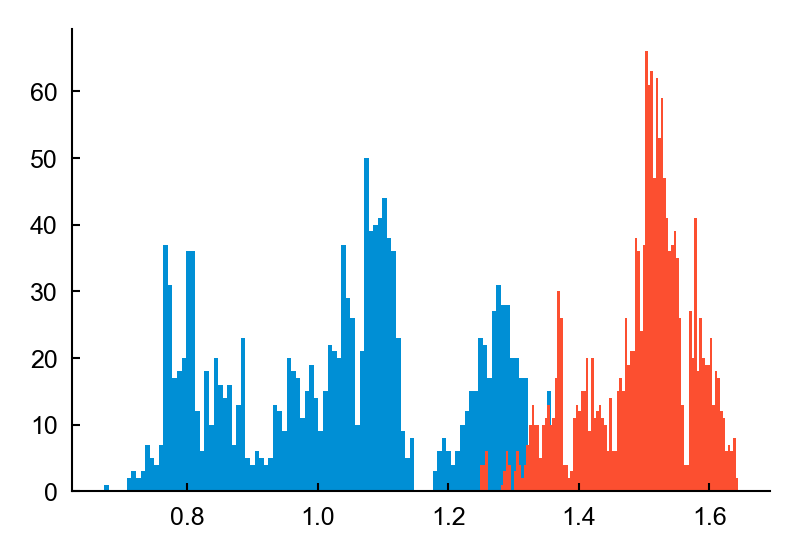

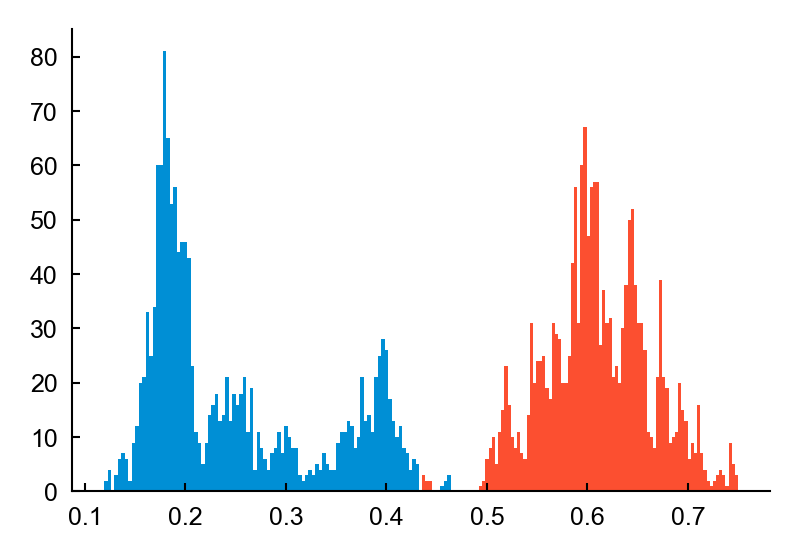

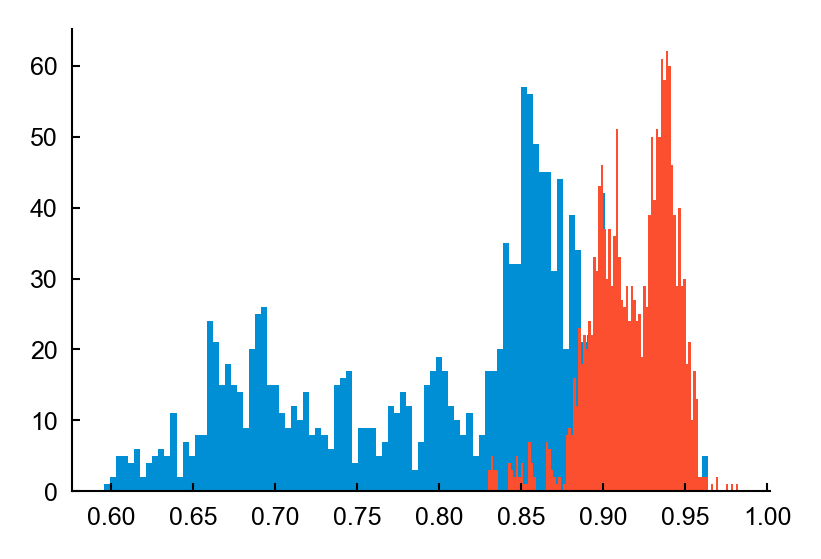

In [59]:
plt.hist(dfa_exp_wake, bins=100)
plt.hist(dfa_exp_anesthesia, bins=100)
plt.show()
plt.hist(mfhurst_b_wake, bins=100)
plt.hist(mfhurst_b_anesthesia, bins=100)
plt.show()
plt.hist(hurst_rs_wake, bins=100)
plt.hist(hurst_rs_anesthesia, bins=100)
plt.show()


In [39]:
delase_wake = DeLASE(wake_responses, dt=dt, n_delays=n_delays, rank=rank, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda', verbose=True)
delase_wake.fit()

delase_anesthesia = DeLASE(anesthesia_responses, dt=dt, n_delays=n_delays, rank=rank, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda', verbose=True)
delase_anesthesia.fit()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing jacobians...
Computing DDE characteristic roots...
Characteristic root computation complete!
Filtering characteristic roots...
Stability analysis complete
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing jacobians...
Computing DDE characteristic roots...
Characteristic root computation complete!
Filtering characteristic roots...
Stability analysis complete


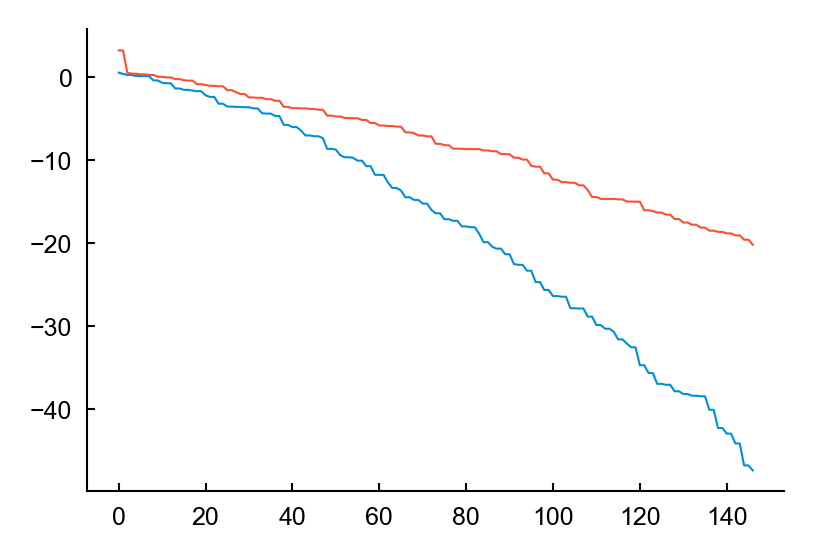

In [40]:
plt.plot(delase_wake.stability_params[:int(0.1*len(delase_wake.stability_params))].cpu().numpy())
plt.plot(delase_anesthesia.stability_params[:int(0.1*len(delase_anesthesia.stability_params))].cpu().numpy())
plt.show()

In [59]:
mean_traj = wake_responses.mean(axis=0)
mean_traj_norm = np.linalg.norm(mean_traj, ord='fro')

In [64]:
def compute_GCV(responses):
    mean_traj = responses.mean(axis=0)
    mean_traj_norm = np.linalg.norm(mean_traj, ord='fro')
    trial_errors = np.zeros(responses.shape[0])
    for i in range(responses.shape[0]):
        trial_errors[i] = np.linalg.norm(responses[i] - mean_traj, ord='fro')
    return np.sqrt(np.mean(trial_errors**2))/mean_traj_norm

In [66]:
compute_GCV(wake_responses), compute_GCV(anesthesia_responses)

(np.float64(2.231034782505589), np.float64(3.487092482860524))

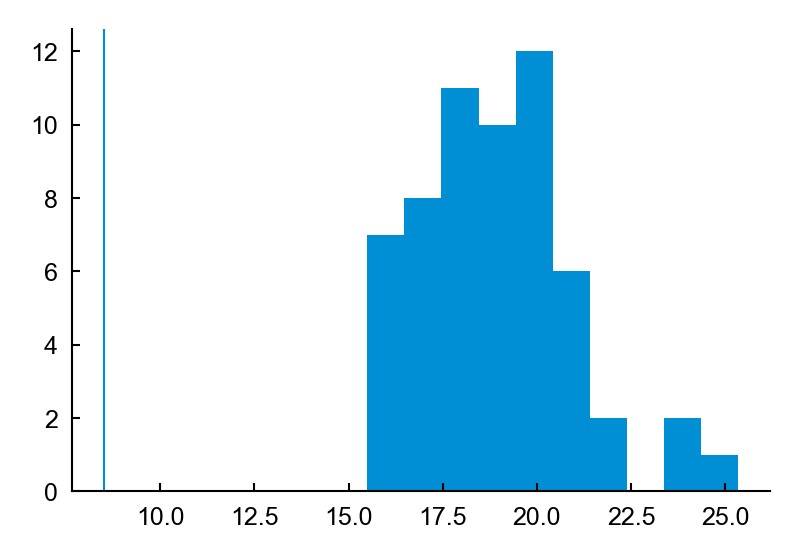

In [61]:
trial_errors = np.zeros(wake_responses.shape[0])
for i in range(wake_responses.shape[0]):
    trial_errors[i] = np.linalg.norm(wake_responses[i] - mean_traj, ord='fro')
plt.hist(trial_errors)
plt.axvline(mean_traj_norm)
plt.show()


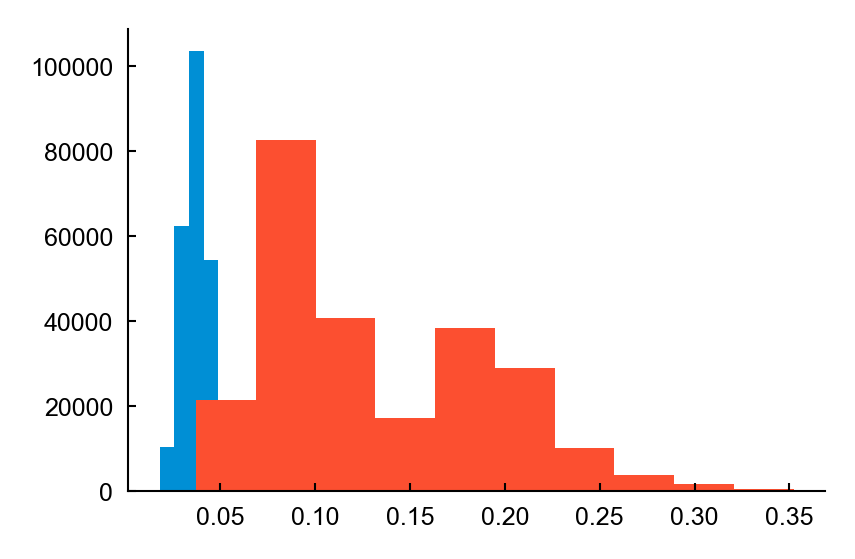

In [ ]:
plt.hist(wake_responses.std(axis=0).flatten())
plt.hist(anesthesia_responses.std(axis=0).flatten())
plt.axvline(wake_responses)
plt.show()

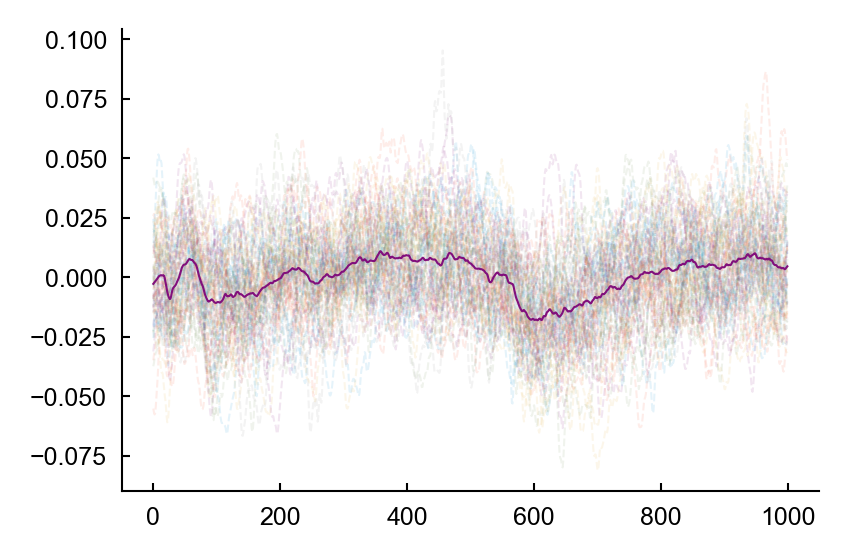

In [51]:
for i in range(wake_responses.shape[0]):
    plt.plot(wake_responses[i, :].mean(axis=-1), linestyle='--', alpha=0.1)
plt.plot(wake_responses.mean(axis=0).mean(axis=-1))
plt.show()